In [49]:
from utilities import *

[Text(0.0, 0, '$t_1$'),
 Text(2.4746339798218666, 0, '$t_2 (t_3)$'),
 Text(7.462872553321062, 0, '$t_4$')]

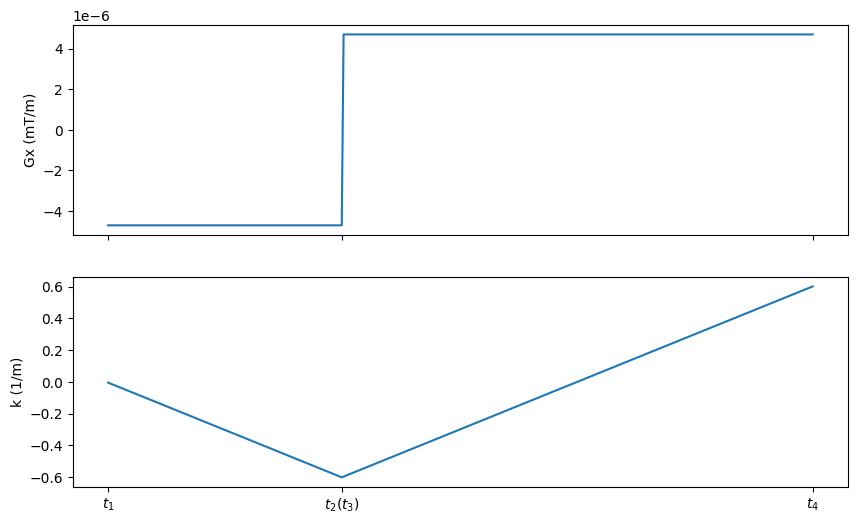

In [50]:
# Environment Setup

# x space (spatial space)
FOV_x = 256 # field of view in x space
N = 256 # sampling points in x space (and k space, time space during ADC)
delta_x = FOV_x / N # sampling interval in x space
x_axis = np.linspace(-FOV_x / 2, FOV_x / 2 - delta_x, N) # symmetric x space

# k space (frequency space)
delta_k = 1 / FOV_x # sampling interval in k space
FOV_k = delta_k * N # field of view in k space
k_axis = np.linspace(-FOV_k / 2, FOV_k / 2 - delta_k, N) # symmetric k space

# gradient
Gx = 4.7e-6 # gradient (T/mm). Note: constant gradient
gamma = 2.68e8 # rad/s/T
gamma_bar = 0.5 * gamma/np.pi # s^-1T^-1

# t space (time space)

gamma_bar_Gx = gamma_bar * Gx * 1e-3
delta_t = delta_k / gamma_bar_Gx # sampling interval in t space (ms)
Ts = FOV_k / gamma_bar_Gx # ADC(rephasing) time (ms)
t_max = 1.5 * Ts - delta_t # maximum time (ms) (rephasing process is 2 times longer than dephasing process)
t_axis = np.linspace(0, t_max, int(N * 1.5))

# Environment Display

fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(10, 6))

Gx_traj = np.concatenate((np.ones(int(N / 2)) * -Gx, np.ones(N) * Gx))
ax1.plot(t_axis, Gx_traj)
ax1.set_ylabel('Gx (mT/m)')

k_traj = np.cumsum(Gx_traj) * 1e3
ax2.plot(t_axis, k_traj)
ax2.set_ylabel('k (1/m)')

ax2.set_xticks([0, t_axis[int(N / 2) - 1], t_axis[int(N * 1.5) - 1]])
ax2.set_xticklabels(['$t_1$', r'$t_2 (t_3)$', r'$t_4$'])

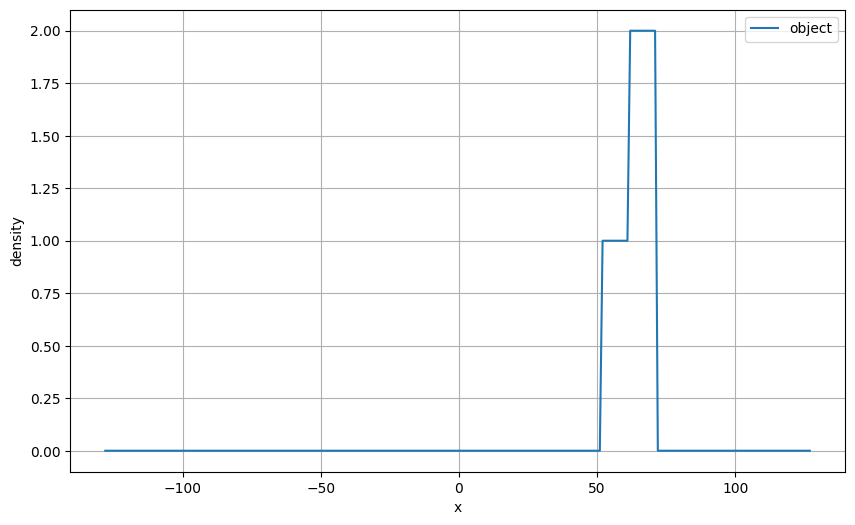

In [51]:
# create object
density = np.zeros(len(x_axis))
density[180:190] = 1
density[190:200] = 2

plt.figure(figsize=(10, 6))
plt.plot(x_axis, density, '-', label='object')
plt.legend()
plt.xlabel('x')
plt.ylabel('density')
plt.grid()

In [52]:
# create spins after the rf pulse (lying on the y-axis)
# assume the spins are lying on each sampling point over y-axis
m0 = 1.0
vec_spins = np.zeros((3, N))
vec_spins[1, :] = 1

# dephasing (t_1 to t_2)
# -Gx on between t1 and t2 (T_s / 2)
w_G = w_grad(w_0=0, G_value=-Gx, gamma=gamma * 1e-3, pos=x_axis, dim=1)
res_1 = multiple_Relaxation(vec_spins, m0, 0, w_G, 1, 1e10, Ts/2, int(N/2), 'z')

store = []
for i in range(2):
    tmp = res_1[i,:,:].squeeze() # shape: (number of steps, number of sampling points)
    
    store.append(tmp @ density) # multiply by true density
# real_part_1, imag_part_1 = store[1], store[0]
Mx_1, My_1 = store[0], store[1]

# rephasing (t_3 to t_4)
# Gx on between t2 and t3 (T_s)
w_G = w_grad(w_0=0, G_value=Gx, gamma=gamma * 1e-3, pos=x_axis, dim=1) # some problem exists here

res_2 = multiple_Relaxation(res_1[:,-1,:], m0, 0, w_G, 1, 1e10, Ts, N, 'z')

store = []
for i in range(2):
    tmp = res_2[i,:,:].squeeze()
    store.append(tmp @ density)
# real_part_2, imag_part_2 = store[1], store[0]
Mx_2, My_2 = store[0], store[1]

Text(0, 0.5, 'signal')

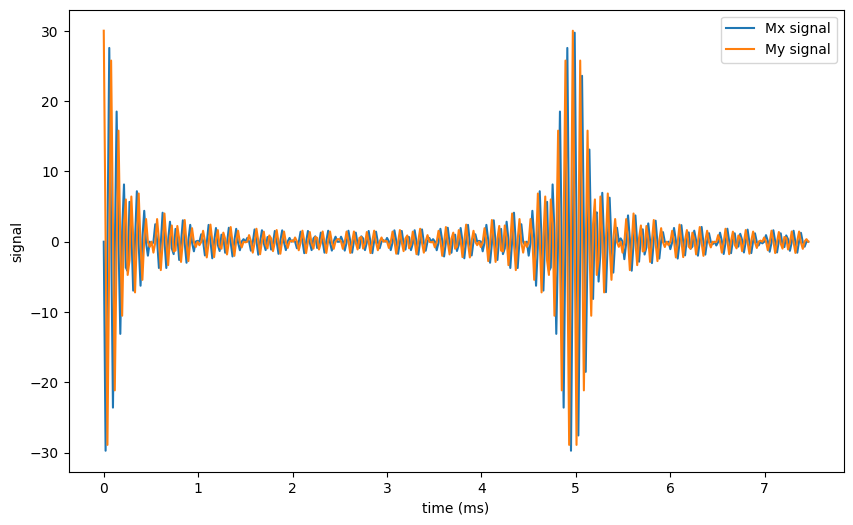

In [53]:
signal_Mx = np.concatenate((Mx_1, Mx_2), axis=0)
signal_My = np.concatenate((My_1, My_2), axis=0)
fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(t_axis, signal_Mx, label='Mx signal')
plt.plot(t_axis, signal_My, label='My signal')
plt.legend()
plt.xlabel('time (ms)')
plt.ylabel('signal')
# print(real_part_1[:10])
# print(imag_part_1[:10])

Text(0, 0.5, 'reconstructed density')

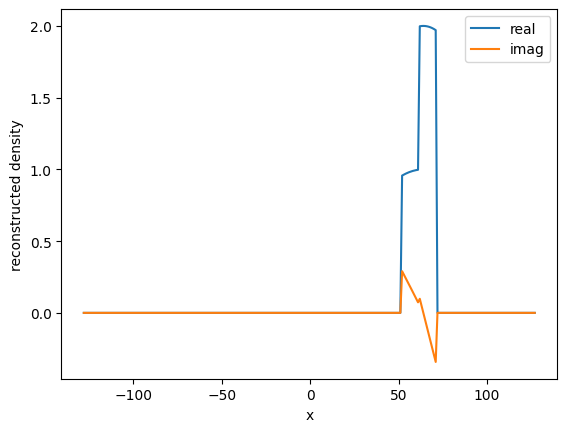

In [54]:
adc_signal = Mx_2 * 1 + 1j * My_2

re_density = np.fft.fftshift(np.fft.ifft(np.fft.fftshift(adc_signal)))
plt.plot(x_axis, np.real(re_density), label='real')
plt.plot(x_axis, np.imag(re_density), label='imag')
plt.legend()
plt.xlabel('x')
plt.ylabel('reconstructed density')

Text(0, 0.5, 'density')

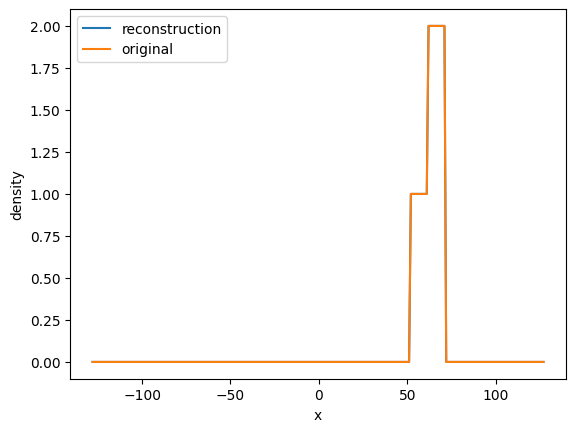

In [55]:
plt.plot(x_axis, np.abs(re_density), label='reconstruction')
plt.plot(x_axis, density, label='original')
plt.legend()
plt.xlabel('x')
plt.ylabel('density')